<a href="https://colab.research.google.com/github/ShamsuriIkhwan/plant-deep-learning/blob/main/augmented_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving dataset 2.rar to dataset 2.rar
User uploaded file "dataset 2.rar" with length 5530236 bytes


In [2]:
#!unzip "/content/drive/path/input_file_name.zip" -d "/content/drive/path/output_folder/"
#!unrar x "/content/drive/path/input_file_name.rar" "/content/drive/path/output_folder/"
!unrar x "/content/dataset 2.rar" "/content/"


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/dataset 2.rar

Creating    /content/New folder (2)                                   OK
Creating    /content/New folder (2)/Diseased                          OK
Extracting  /content/New folder (2)/Diseased/diseased (1).jpg              0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (10).jpg             0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (100).jpg            0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (101).jpg            0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (102).jpg            0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (103).jpg            0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (104).jpg            0%  OK 
Extracting  /content/New folder (2)/Diseased/diseased (105).jpg            0%  OK 
Ex

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from PIL import Image

In [4]:
# Set the path to the original dataset folder
dir = '/content/New folder (2)'

# Set the path to the augmented dataset folder
aug_dir = '/content/aug_dataset'


# Print the class names and the number of samples before augmentation
#227
for class_name in os.listdir(dir):
    class_path = os.path.join(dir, class_name)
    if os.path.isdir(class_path):
        num_samples = len(os.listdir(class_path))
        print(f"Class: {class_name}, Samples: {num_samples}")

num_dir_classes=len(os.listdir(dir))
print("\n","There are", num_dir_classes, "classes in the folder\n")

Class: Healthy, Samples: 400
Class: Diseased, Samples: 400

 There are 2 classes in the folder



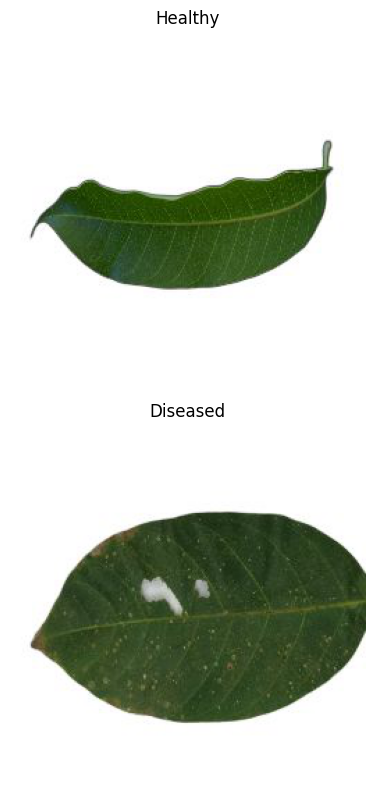

In [5]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Iterate over the class names
for i, class_name in enumerate(os.listdir(dir)):
    class_path = os.path.join(dir, class_name)
    if os.path.isdir(class_path):
        image_files = os.listdir(class_path)

        # Randomly select an image from the class
        selected_image_file = random.choice(image_files)
        image_path = os.path.join(class_path, selected_image_file)
        image = plt.imread(image_path)

        # Plot the image in the corresponding subplot
        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
# Set the path to the resized augmented dataset folders
resize_224_dir = '/content/resized_aug_dataset_224'
resize_227_dir = '/content/resized_aug_dataset_227'

# Perform data augmentation for each class
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Iterate over the classes in the original dataset
for class_name in os.listdir(dir):
    class_path = os.path.join(dir, class_name)
    if os.path.isdir(class_path):
        class_images = os.listdir(class_path)
        num_samples = len(class_images)

        # Create a directory for the current class in the augmented dataset folder
        aug_class_dir = os.path.join(aug_dir, class_name)
        os.makedirs(aug_class_dir, exist_ok=True)

        # Copy original images to the augmented dataset folder
        for image_name in class_images:
            original_image_path = os.path.join(class_path, image_name)
            target_image_path = os.path.join(aug_class_dir, image_name)
            copyfile(original_image_path, target_image_path)

            # Apply data augmentation and save augmented images
            img = tf.keras.preprocessing.image.load_img(original_image_path)
            x = tf.keras.preprocessing.image.img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in datagen.flow(x, batch_size=16,
                                      save_to_dir=aug_class_dir,
                                      save_prefix='aug_' + class_name + '_',
                                      save_format='jpg'):
                i += 1
                if i > 9:
                    break

        # Resize augmented images to 224x224 and save in separate folder
        resize_224_class_dir = os.path.join(resize_224_dir, class_name)
        os.makedirs(resize_224_class_dir, exist_ok=True)
        for image_name in os.listdir(aug_class_dir):
            image_path = os.path.join(aug_class_dir, image_name)
            image = Image.open(image_path)
            resized_image = image.resize((224, 224))
            resized_image_path = os.path.join(resize_224_class_dir, image_name)
            resized_image.save(resized_image_path)

        # Resize augmented images to 227x227 and save in separate folder
        resize_227_class_dir = os.path.join(resize_227_dir, class_name)
        os.makedirs(resize_227_class_dir, exist_ok=True)
        for image_name in os.listdir(aug_class_dir):
            image_path = os.path.join(aug_class_dir, image_name)
            image = Image.open(image_path)
            resized_image = image.resize((227, 227))
            resized_image_path = os.path.join(resize_227_class_dir, image_name)
            resized_image.save(resized_image_path)

In [7]:
# Set the path to store the split dataset
split_dir = '/content/split_dataset'

# Define the train, validation, and test ratios
train_ratio = 0.8
valid_ratio = 0.15
test_ratio = 0.05

# Function to split a dataset into train, validation, and test sets
def split_dataset(data_dir, split_dir):
    os.makedirs(split_dir, exist_ok=True)

    # Create train, valid, and test directories for each size
    sizes = ['224x224', '227x227']
    for size in sizes:
        size_dir = os.path.join(split_dir, size)
        os.makedirs(size_dir, exist_ok=True)
        train_dir = os.path.join(size_dir, 'train')
        valid_dir = os.path.join(size_dir, 'valid')
        test_dir = os.path.join(size_dir, 'test')
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(valid_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

    # Iterate over the classes
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            class_images = os.listdir(class_dir)
            num_samples = len(class_images)
            num_train = int(num_samples * train_ratio)
            num_valid = int(num_samples * valid_ratio)
            num_test = num_samples - num_train - num_valid

            # Shuffle the image list
            random.shuffle(class_images)

            # Split images into train, valid, and test sets
            train_images = class_images[:num_train]
            valid_images = class_images[num_train:num_train+num_valid]
            test_images = class_images[num_train+num_valid:]

            # Copy images to respective directories for each size
            for size in sizes:
                size_dir = os.path.join(split_dir, size)
                train_dir = os.path.join(size_dir, 'train', class_name)
                valid_dir = os.path.join(size_dir, 'valid', class_name)
                test_dir = os.path.join(size_dir, 'test', class_name)
                os.makedirs(train_dir, exist_ok=True)
                os.makedirs(valid_dir, exist_ok=True)
                os.makedirs(test_dir, exist_ok=True)

                for image_name in train_images:
                    src_path = os.path.join(class_dir, image_name)
                    dst_path = os.path.join(train_dir, image_name)
                    shutil.copy(src_path, dst_path)

                for image_name in valid_images:
                    src_path = os.path.join(class_dir, image_name)
                    dst_path = os.path.join(valid_dir, image_name)
                    shutil.copy(src_path, dst_path)

                for image_name in test_images:
                    src_path = os.path.join(class_dir, image_name)
                    dst_path = os.path.join(test_dir, image_name)
                    shutil.copy(src_path, dst_path)

# Split the resized 224x224 dataset
split_dataset(resize_224_dir, split_dir)

# Split the resized 227x227 dataset
split_dataset(resize_227_dir, split_dir)

In [8]:
import os

# Set the path to the split dataset folder
split_dir = '/content/split_dataset'

# Function to count the number of images in a directory
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Count the number of images in each folder within 224x224 directory
size_224_dir = os.path.join(split_dir, '224x224')
for subset in ['train', 'valid', 'test']:
    subset_dir = os.path.join(size_224_dir, subset)
    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        num_images = count_images_in_directory(class_dir)
        print(f"224x224/{subset}/{class_name}: {num_images} images")

# Count the number of images in each folder within 227x227 directory
size_227_dir = os.path.join(split_dir, '227x227')
for subset in ['train', 'valid', 'test']:
    subset_dir = os.path.join(size_227_dir, subset)
    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        num_images = count_images_in_directory(class_dir)
        print(f"227x227/{subset}/{class_name}: {num_images} images")


224x224/train/Healthy: 3563 images
224x224/train/Diseased: 3546 images
224x224/valid/Healthy: 1030 images
224x224/valid/Diseased: 1023 images
224x224/test/Healthy: 363 images
224x224/test/Diseased: 360 images
227x227/train/Healthy: 3563 images
227x227/train/Diseased: 3546 images
227x227/valid/Healthy: 1030 images
227x227/valid/Diseased: 1023 images
227x227/test/Healthy: 363 images
227x227/test/Diseased: 360 images


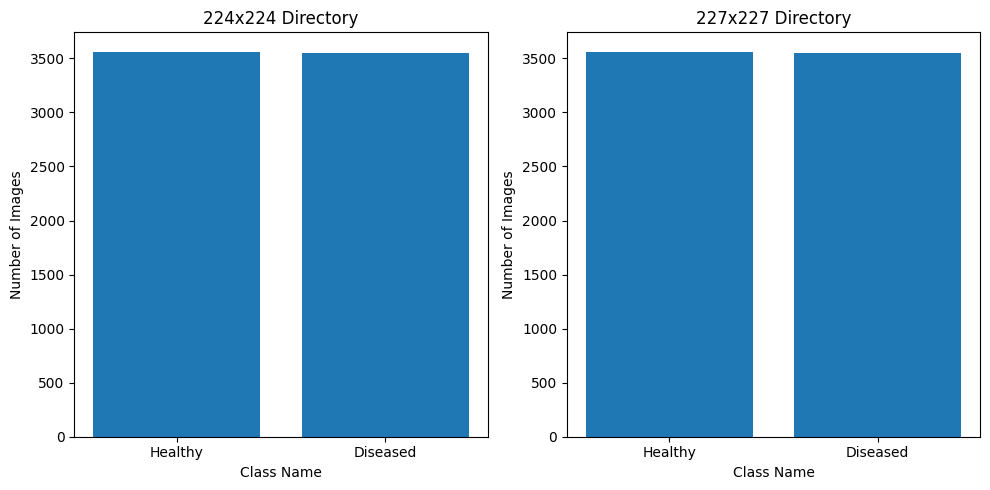

In [9]:
import os
import matplotlib.pyplot as plt

# Set the path to the split dataset folder
split_dir = '/content/split_dataset'

# Function to count the number of images in a directory
def count_images_in_directory(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        count += len(files)
    return count

# Initialize lists to store the class names and image counts
class_names_224 = []
image_counts_224 = []
class_names_227 = []
image_counts_227 = []

# Count the number of images in each folder within 224x224 directory
size_224_dir = os.path.join(split_dir, '224x224')
for subset in ['train', 'valid', 'test']:
    subset_dir = os.path.join(size_224_dir, subset)
    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        num_images = count_images_in_directory(class_dir)
        class_names_224.append(class_name)
        image_counts_224.append(num_images)

# Count the number of images in each folder within 227x227 directory
size_227_dir = os.path.join(split_dir, '227x227')
for subset in ['train', 'valid', 'test']:
    subset_dir = os.path.join(size_227_dir, subset)
    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        num_images = count_images_in_directory(class_dir)
        class_names_227.append(class_name)
        image_counts_227.append(num_images)

# Create bar plots for 224x224 and 227x227 directories
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(class_names_224, image_counts_224)
plt.title("224x224 Directory")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")

plt.subplot(1, 2, 2)
plt.bar(class_names_227, image_counts_227)
plt.title("227x227 Directory")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")

plt.tight_layout()
plt.show()


In [10]:
#!zip -r "/content/drive/path/output_file_name.zip" "/content/drive/My Drive/filepathtozip"
!zip -r "/content/aug_dataset.zip" "/content/aug_dataset"
!zip -r "/content/resized_aug_dataset_224.zip" "/content/resized_aug_dataset_224"
!zip -r "/content/resized_aug_dataset_227.zip" "/content/resized_aug_dataset_227"
!zip -r "/content/split_dataset.zip" "/content/split_dataset"

Streaming output truncated to the last 5000 lines.
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_3892.jpg (deflated 15%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_1760.jpg (deflated 24%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_6401.jpg (deflated 22%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_2566.jpg (deflated 9%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_9771.jpg (deflated 24%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_5266.jpg (deflated 20%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_5570.jpg (deflated 8%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_3316.jpg (deflated 18%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_6432.jpg (deflated 15%)
  adding: content/split_dataset/224x224/train/Healthy/aug_Healthy__0_2115.jpg (deflated 12%)
  adding: content/spl

In [11]:
from google.colab import files
#files.download("/content/file.zip")
files.download("/content/aug_dataset.zip")
files.download("/content/resized_aug_dataset_224.zip")
files.download("/content/resized_aug_dataset_227.zip")
files.download("/content/split_dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
!cp -r "/content/aug_dataset.zip" "/content/drive/MyDrive/project fyp"
!cp -r "/content/resized_aug_dataset_224.zip" "/content/drive/MyDrive/project fyp"
!cp -r "/content/resized_aug_dataset_227.zip" "/content/drive/MyDrive/project fyp"
!cp -r "/content/split_dataset.zip" "/content/drive/MyDrive/project fyp"

In [ ]:
!cp -r "/content/aug_dataset" "/content/drive/MyDrive/project fyp"
!cp -r "/content/resized_aug_dataset_224" "/content/drive/MyDrive/project fyp"
!cp -r "/content/resized_aug_dataset_227" "/content/drive/MyDrive/project fyp"
!cp -r "/content/split_dataset" "/content/drive/MyDrive/project fyp"